# Stock price prediction

Predict company closing stock price using LSTM model, based on the sotck price of th 60 previous days.

In [198]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from datetime import date
import yfinance as yf
from sklearn.metrics import mean_squared_error as mse

In [199]:
from tqdm.notebook import tqdm as tqdm_notebook
from statsmodels.tsa.arima.model import ARIMA

## 1) Data preparation

Fetch stock price data for a given company (use-case Apple)

In [200]:
start_date = '2000-01-01'
end_date = date.today().strftime("%Y-%m-%d")
company_code = 'AAPL' #American Airlines

In [201]:
df = yf.download(tickers = company_code, start = start_date, end = end_date)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.847207,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.775779,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.787131,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719014,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.753073,460734400


Closing price history visualization

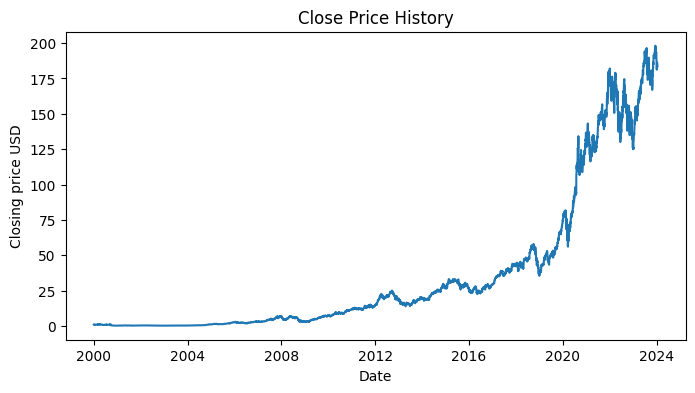

In [202]:
plt.figure(figsize=(8,4))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing price USD')
plt.show()

In [203]:
data = df['Close']
dataset = data.values #df to numpy array
len(dataset)

6047

Split training / testing data

In [204]:
train_split = int(len(data)*0.9)
val_split = int(len(data)*0.05)
y_train = data[0:train_split]
X_train = np.arange(0,len(y_train),1).reshape(-1,1)
X_tot =  np.arange(0,len(data),1).reshape(-1,1)
X_val = np.arange(train_split,train_split+val_split,1).reshape(-1,1)
X_test = np.arange(train_split+val_split,len(data),1).reshape(-1,1)
y_val = data[train_split:train_split+val_split]

time = np.array(df.index)
time = pd.to_datetime(time)

## 2) Long term trend

Using polynomial regression to analyze and potentially predict long term trend.

In [205]:
# Find optimal polynomial regressor
mse_list = []
degrees = np.arange(2,15,1)
for d in degrees:
    poly = PolynomialFeatures(d)
    new_X_train = poly.fit_transform(X_train)
    lr = LinearRegression()
    lr.fit(new_X_train,y_train)
    new_X_val = poly.fit_transform(X_val)
    y_pred = lr.predict(new_X_val)
    mse_list.append(mse(y_pred,y_val))

In [206]:
mse_data = pd.DataFrame({'MSE':mse_list,'Degrees':degrees}).sort_values(by='MSE')
mse_data.head()

,MSE,Degrees
11,216.255339,13
2,480.418167,4
10,587.390210,12
1,947.829696,3
3,1510.261446,5


Build optimal model

In [207]:
opt_degree = 3
poly = PolynomialFeatures(opt_degree)
new_X_tot = poly.fit_transform(X_tot)
new_X_train = poly.fit_transform(X_train)
new_X_val = poly.fit_transform(X_val)
new_X_test = poly.fit_transform(X_test)

In [208]:
lr = LinearRegression()
lr.fit(new_X_train,y_train)
y_pred_train = lr.predict(new_X_train)
y_pred_val = lr.predict(new_X_val)
y_pred_test = lr.predict(new_X_test)

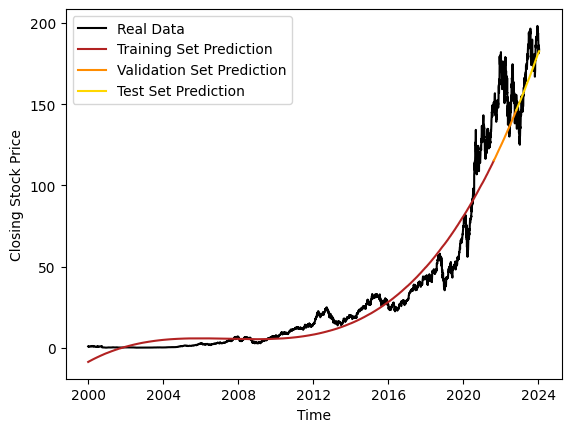

In [209]:
plt.plot(time,dataset,color='k',label='Real Data')
plt.xlabel('Time')
plt.ylabel('Closing Stock Price')
plt.plot(time[0:train_split],y_pred_train,color='firebrick',label='Training Set Prediction')
plt.plot(time[train_split:train_split+val_split],y_pred_val,color='darkorange',label='Validation Set Prediction')
plt.plot(time[train_split+val_split::],y_pred_test,color='gold',label='Test Set Prediction')
plt.legend()

Remove trend from data for short term predicions

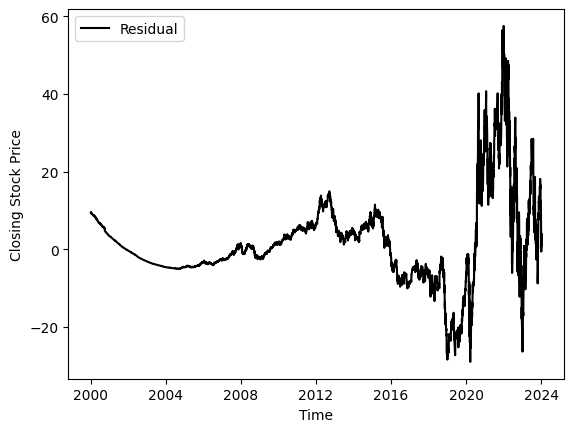

In [210]:
y_pred = lr.predict(new_X_tot)
y_detrend = dataset-y_pred
plt.plot(time,y_detrend,label='Residual',color='k')
plt.xlabel('Time')
plt.ylabel('Closing Stock Price')
plt.legend()

In [211]:
detrend_data = pd.DataFrame([time,y_detrend]).T
detrend_data = detrend_data.rename(columns={0:'Date',1:'y'})

In [212]:
detrend_data.head()

,Date,y
0,2000-01-03,9.522937
1,2000-01-04,9.413702
2,2000-01-05,9.402149
3,2000-01-06,9.296876
4,2000-01-07,9.312166


## 3) Short term prediction

Using the ARIMA model to predict closing stock price for the upcoming days.

In [213]:
# Only consider data since 2020
min_month_index = detrend_data[detrend_data['Date']=='2020-01-02'].index[0]
min_index = min_month_index + np.argmin(detrend_data[min_month_index:min_month_index+30].y)
new_data = detrend_data[min_index::]
new_data = new_data.reset_index().drop('index',axis=1)

In [214]:
start = 50
train_size = 40
pred_size = 3
new_data_train = new_data[start: start+train_size+1]
new_data_test = new_data[start+train_size:start+train_size+pred_size]

Optimization process

In [215]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        #try: 
        model = ARIMA(exog, order=order).fit()
    #except:
    #        continue
            
        aic = model.aic
        results.append([order, model.aic])
    #print(results)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [216]:
series = new_data_train.y
series = series.astype('float')

In [217]:
ps = range(0, 5, 1)
d = 0
qs = range(0, 5, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

result_d_0 = optimize_ARIMA(order_list, exog = series)

  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting

In [218]:
result_d_0.head()

,"(p, d, q)",AIC
0,"(1, 0, 0)",180.419357
1,"(2, 0, 0)",181.832548
2,"(1, 0, 1)",181.984499
3,"(3, 0, 0)",182.794800
4,"(1, 0, 2)",182.814221


In [219]:
best_models = result_d_0.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_0 = ARIMA(series, order=best_model_params_0).fit()
print(best_model_0.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   41
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -87.210
Date:                Wed, 17 Jan 2024   AIC                            180.419
Time:                        15:16:01   BIC                            185.560
Sample:                             0   HQIC                           182.291
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5877      4.051     -4.342      0.000     -25.527      -9.649
ar.L1          0.9237      0.058     16.005      0.000       0.811       1.037
sigma2         3.9332      0.912      4.311      0.0

In [220]:
test_size = len(new_data_test)
fore_l= test_size+3
forecast = best_model_0.get_prediction(start=train_size+1, end=train_size+fore_l-3)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.25)

C:\Users\Amine\AppData\Local\Temp\ipykernel_36744\4011354030.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(new_data_train.Date, new_data_train.y[0::] ,color='navy',marker='x',label='Training Set')
C:\Users\Amine\AppData\Local\Temp\ipykernel_36744\4011354030.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(new_data_test.Date,new_data_test.y[0::] ,color='firebrick',marker='x',label='Test Set')


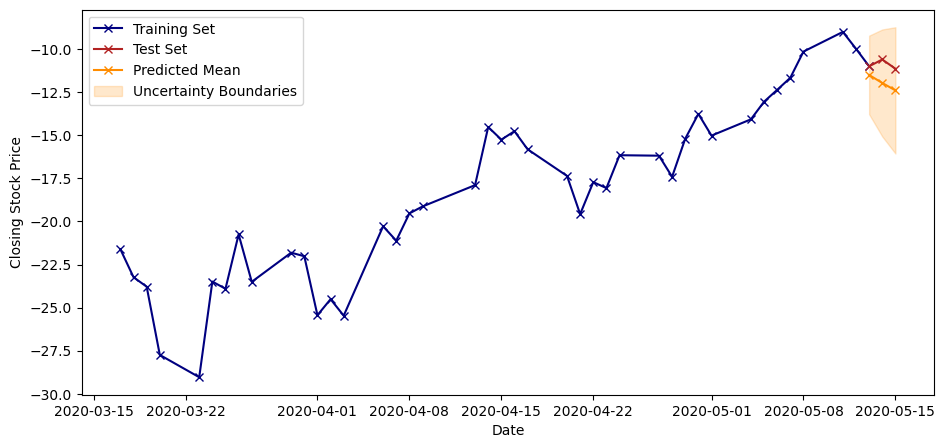

In [223]:
plt.figure(figsize = (11,5))
plt.plot(new_data_train.Date, new_data_train.y[0::] ,color='navy',marker='x',label='Training Set')
plt.plot(new_data_test.Date,new_data_test.y[0::] ,color='firebrick',marker='x',label='Test Set')
plt.fill_between(new_data_test.Date,ci['lower y'], ci['upper y'],alpha=0.2,color='darkorange',label='Uncertainty Boundaries')
plt.plot(new_data_test.Date, forec,label='Predicted Mean',color='darkorange',marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.show()